## Identify IR Excess White Dwarfs

In [1]:
# general python imports
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# general astronomy imports
from astropy.io import fits
from astropy.table import Table, join, join_skycoord, unique, vstack, hstack
import pyphot
from pyphot import unit
from pyvo import registry  # version >=1.4.1 
from astroquery.gaia import Gaia
from astroquery.xmatch import XMatch
import corv

# imports for extinction correction
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query
import extinction

# imports for acccessing sdss5 data
from stefansecrets import keys
import pandas as pd
import fsspec
import requests
import aiohttp

plt.style.use('stefan.mplstyle')

Could not import regions, which is required for some of the functionalities of this module.
/home/arsen/miniconda3/envs/ir-excess/lib/python3.12/site-packages/corv/models/warwick_da
We could not find the pickled WD models
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


## 01 - Sample Selection
---

Our parent sample is the catalog of 359073 high-confidence white dwarfs in Gaia eDR3 from [Gentile-Fusillo et. al. 2021](https://academic.oup.com/mnras/article/508/3/3877/6373953#306804563). We cross-match this sample against the database of infrared photometric observations from unWISE.

In [2]:
# WD catalog from Gentile-Fusillo+21: https://academic.oup.com/mnras/article/508/3/3877/6373953#306804563
wd_catalog = Table.read('https://warwick.ac.uk/fac/sci/physics/research/astro/research/catalogues/gaiaedr3_wd_main.fits.gz') # all wds in gaia
wd_catalog = wd_catalog[wd_catalog['Pwd'] > 0.75] # re-create Gentile-Fusillo+21's criteria for a high-confidence WD
wd_catalog[['source_id', 'ra', 'dec']].write('data/gentile_fusillo+2021_wds.dat', overwrite=True, format='ipac')
print(f'WDs from Gentile-Fusillo+21:', len(wd_catalog))

WDs from Gentile-Fusillo+21: 359073


Cross-matching is being a pain in the ass right now, so I'm going to do it manually. I've saved `source_ids`, `ras`, and `decs` in the file `data/gentile_fusillo+2021_wds.dat`, which is the format taken by [NASA/IPAC XMatch Service](https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd). I'll go there, upload the table, and run the cross-match without one-to-one matching and with a search radius of 10 arcseconds. My method for position cross-matching is to take a much greater area than I'd need then cut at the inflection point based on the idea that the number of sources in the background should increase as $$\frac{dN}{dr} = 2\pi r n.$$ The results of the cross-match are saved as the file `data/gentile_fusillo+2021_xmatch_WISE.dat`. Once this is set, I can join the xmatched table back with the original white dwarf catalog in such a way that the non-WISE rows are dropped. I really wish there was an easy way to programatically cross-match very large tables without having to break the Jupyter Notebook immersion.

For interpreting the returned data:
* The original paper with the catalog information is [ Schlafly, Meisner, and Green, 2019.](https://ui.adsabs.harvard.edu/abs/2019ApJS..240...30S/abstract)
* IRSA gives a description of each column [here.](https://irsa.ipac.caltech.edu/data/WISE/unWISE/gator_docs/unwise_colDescriptions.html)

In [3]:
# read the xmatched tables
wise_xmatch = Table.read('data/gentile_fusillo+2021_xmatch_WISE.dat', format='ipac')

# if a column name ends in '_01', remove that part of the string
keys_mod, keys_orig = ([s[:-3] for s in wise_xmatch.keys() if s.endswith("_01")], [s for s in wise_xmatch.keys() if s.endswith("_01")])
wise_xmatch.remove_columns(['ra', 'dec'])
wise_xmatch.rename_columns(keys_orig, keys_mod)

WDs with WISE observations: 57108


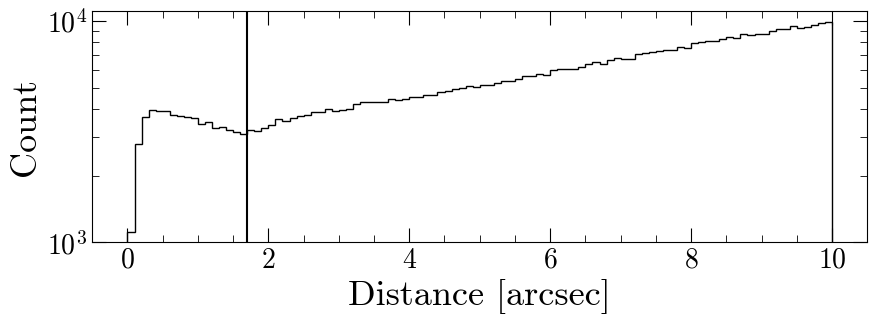

In [4]:
# choose only the real matches
angdist = 1.7 # maximum angular distance

plt.figure(figsize = (10,3))
plt.hist(wise_xmatch['dist_x'], bins = 100, color = 'k', histtype = 'step')
plt.axvline(x = angdist, c = 'k')
plt.yscale('log')
plt.xlabel('Distance [arcsec]')
plt.ylabel('Count')

wise_xmatch = wise_xmatch[wise_xmatch['dist_x'] < angdist]
print(f'WDs with WISE observations:', len(wise_xmatch))

In [5]:
# now match the two on the gaia source_id
catalog = join(wd_catalog, wise_xmatch, keys='source_id')

catalog.sort('dist_x') # sort the catalog in ascending order of angular separation
catalog = unique(catalog, keys='source_id') # take the unique source_ids, keeping the first one
catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
print(f'n xmatched white dwarfs={len(catalog)}' )

del wise_xmatch, wd_catalog # delete unnecessary variables to save memory

n xmatched white dwarfs=53078


In [6]:
# catalog cleaning
catalog = catalog[catalog['r_med_geo'] < 2000] # restrict the sample to within 2000pc
catalog = catalog[catalog['parallax_over_error'] > 10] # only take well-resolved targets

## 02 - Analysis
---

In [7]:
# convert the provided WISE fluxes into usable units
lib = pyphot.get_library()
f = [lib['WISE_RSR_W1'], lib['WISE_RSR_W2']] # define the WISE filters

# signal-to-noise ratio is flux over error
catalog['w1snr'] = catalog['flux_1'] / catalog['dflux_1'];
catalog['w2snr'] = catalog['flux_2'] / catalog['dflux_2'];

# convert to magnitudes, see p.15 of https://ui.adsabs.harvard.edu/abs/2019ApJS..240...30S/abstract
catalog['w1mpro'] = 22.5 - 2.5*np.log10(catalog['flux_1'])
catalog['w2mpro'] = 22.5 - 2.5*np.log10(catalog['flux_2']) 

# calculate magnitude uncertainties
catalog['w1sigm'] = catalog['dflux_1'] / (1.09 * catalog['flux_1']);
catalog['w2sigm'] = catalog['dflux_2'] / (1.09 * catalog['flux_2']);

/tmp/ipykernel_13057/2620154823.py:10: RuntimeWarning: divide by zero encountered in log10
  catalog['w1mpro'] = 22.5 - 2.5*np.log10(catalog['flux_1'])
/tmp/ipykernel_13057/2620154823.py:11: RuntimeWarning: divide by zero encountered in log10
  catalog['w2mpro'] = 22.5 - 2.5*np.log10(catalog['flux_2'])


In [8]:
# quality filter the dataset (flag explanation: https://catalog.unwise.me/files/unwise_bitmask_writeup-03Dec2018.pdf)
mask = np.all([catalog['w1snr'] > 3, catalog['w2snr'] > 3, # only select rows with W1 & W2 SNR > 3
               catalog['flags_unwise_1'] == 0, catalog['flags_unwise_2'] == 0], # discard rows with flags indicating crowded field, diffraction spikes, etc
               axis=0)
catalog = catalog[mask] # apply the filter
print(f'n WDs with good WISE photometry={len(catalog)}')

n WDs with good WISE photometry=10236


Apply de-reddening.

In [9]:
from __future__ import print_function

# create a new column in catalog containing the skycoord object for each star using the bailer-jones distances
coords = [SkyCoord(frame="icrs", ra=catalog['ra'][i]*u.deg, dec=catalog['dec'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

# query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query() # instantiate the Edenhofer query
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0 # don't correct any rows with failed queries

Optimizing map for querying (this might take a couple of seconds)...


In [10]:
# convert to actual units (todo: check the dustmaps docs)
Ebv = bsq_res*0.901*0.98 # i don't totally remember the details of why this is necessary
catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = Ebv*0.2

# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# fetch Gaia photometric band pivot wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]
gaia_phot_wavl = np.array([filter.lpivot.to('angstrom').value for filter in gaia_filters])

# for each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# save the extinction in each band
catalog['G_ext'] = ext_all.T[0]
catalog['BP_ext'] = ext_all.T[1]
catalog['RP_ext'] = ext_all.T[2]
catalog['W1_ext'] = ext_all.T[3]
catalog['W2_ext'] = ext_all.T[4]

# subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['phot_g_mean_mag'] - catalog['G_ext']
catalog['GAIA_BP'] = catalog['phot_bp_mean_mag'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['phot_rp_mean_mag'] - catalog['RP_ext']
catalog['WISE_W1'] = catalog['w1mpro'] - catalog['W1_ext']
catalog['WISE_W2'] = catalog['w2mpro'] - catalog['W2_ext']

# delete bayestar query because it uses a lot of memory
del bsq

In [11]:
# save absolute magnitudes and useful colors into the table for easy access later
abs_mag = lambda row: catalog[row] - 5 * np.log10(catalog['r_med_geo']) + 5

catalog['abs_g'] = abs_mag('GAIA_G')
catalog['abs_bp'] = abs_mag('GAIA_BP')
catalog['abs_rp'] = abs_mag('GAIA_RP')
catalog['abs_w1'] = abs_mag('WISE_W1')
catalog['abs_w2'] = abs_mag('WISE_W2')

catalog['bp_rp'] = catalog['abs_bp'] - catalog['abs_rp']

In [12]:
# calculate the infrared excess compared to a lone WD

lib = pyphot.get_library()
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP'], lib['WISE_RSR_W1'], lib['WISE_RSR_W2']]
base_wavl, tremblay, model_spec_low_logg, table = corv.utils.build_warwick_da(flux_unit = 'flam') # fetch the Warwick DA models used in corv

# instantiate containers for the differences
bp_rp = []
rp_w1 = []
rp_w2 = []
g = []
# ------------------------------------------

# grid parameters ---------------------
logg = 8
teffs = np.linspace(5000, 120000, 500)
# -------------------------------------

# compute photometry for a grid of white dwarfs
for i in tqdm(range(len(teffs))):
    spec = tremblay((teffs[i], logg)) # generate the surface flux from parameters

    # convolve down to fluxes
    fluxes = [filters[j].get_flux(base_wavl * unit['angstrom'], spec* unit['erg/s/cm**2/angstrom'], axis=1).to('erg/s/cm**2/angstrom').value for j in range(len(filters))]
    mags = [-2.5 * np.log10(fluxes[j]) - filters[j].Vega_zero_mag for j in range(len(filters))] # convert to Vega mags
    
    # save computed colors
    bp_rp.append(mags[1] - mags[2])
    rp_w1.append(mags[2] - mags[3])
    rp_w2.append(mags[2] - mags[4])
    
# sort the color lists so that we can interpolate
bp_rp = list(reversed(bp_rp))
rp_w1 = list(reversed(rp_w1))
rp_w2 = list(reversed(rp_w2))

# calculate the expeceted rp_wn color by interpolating from the bp_rp/rp_wn color color diagram, then compute the difference
catalog['w1_diffs'] = (catalog['abs_rp'] - catalog['abs_w1']) - np.interp(catalog['bp_rp'], bp_rp, rp_w1)
catalog['w2_diffs'] = (catalog['abs_rp'] - catalog['abs_w2']) - np.interp(catalog['bp_rp'], bp_rp, rp_w2)

/home/arsen/miniconda3/envs/ir-excess/lib/python3.12/site-packages/corv/models/warwick_da


100%|██████████| 500/500 [00:17<00:00, 28.10it/s]


In [13]:
# filter out any infinities in the data
mask = np.all([~np.isinf(catalog['w1_diffs']), ~np.isinf(catalog['w1_diffs'])], axis=0)
catalog = catalog[mask]

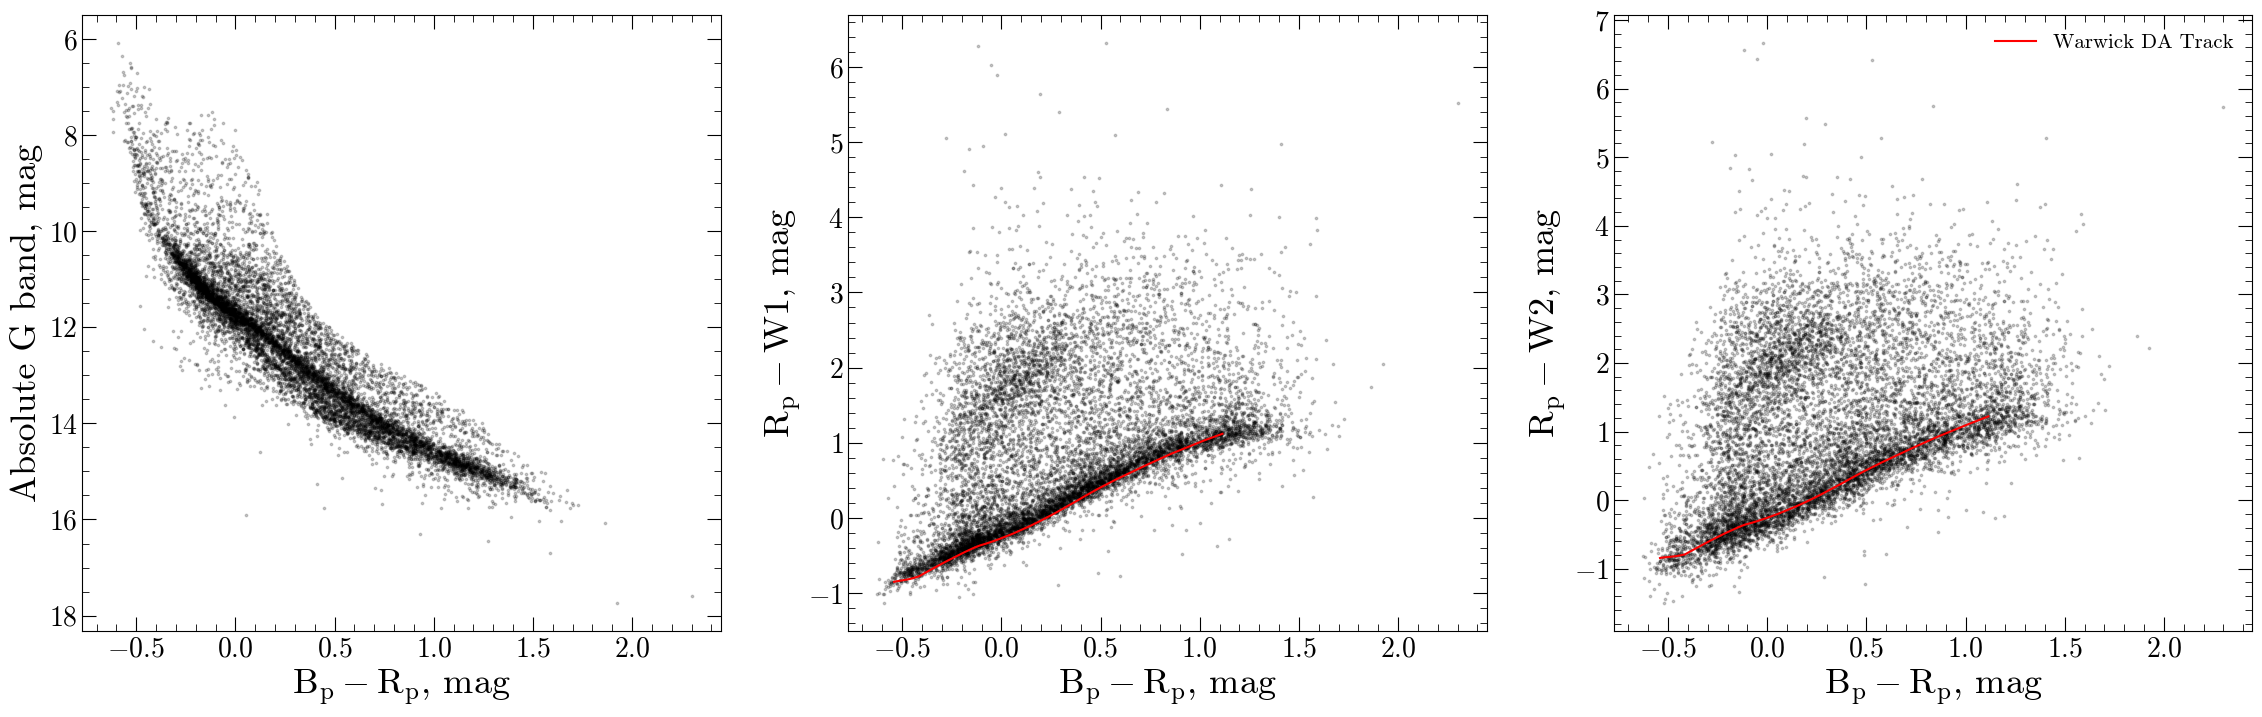

In [14]:
# sanity plots
plt.figure(figsize=(28,8))

plt.subplot(1,3,1) # color-magnitude diagram
plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.2)
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')
plt.gca().invert_yaxis()

plt.subplot(1,3,2) # color-color diagram for bp-rp vs. g-W1
plt.scatter(catalog['bp_rp'], catalog['abs_rp'] - catalog['abs_w1'], s = 3, c = 'k', alpha = 0.2)
plt.plot(bp_rp, rp_w1, c='red', label='Warwick DA Track')
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('$R_p-W1$, mag')

plt.subplot(1,3,3) # color-color diagram for bp-rp vs. g-W2
plt.scatter(catalog['bp_rp'], catalog['abs_rp'] - catalog['abs_w2'], s = 3, c = 'k', alpha = 0.2)
plt.plot(bp_rp, rp_w2, c='red', label='Warwick DA Track')
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('$R_p-W2$, mag')
plt.legend(framealpha=0)

In [15]:
# compute the principal component of the diffs
diffs = np.array([catalog['w1_diffs'], catalog['w2_diffs']]).T # assign everything into a matrix
Q = diffs.T @ diffs # compute the covariances (see https://en.wikipedia.org/wiki/Principal_component_analysis#Covariances)
W, V = np.linalg.eig(Q) # compute eigenvectors W and eigenvalues V
m = V[:,1] / V[:,0]

cutoff_line = lambda x: m[1]*x+2.3

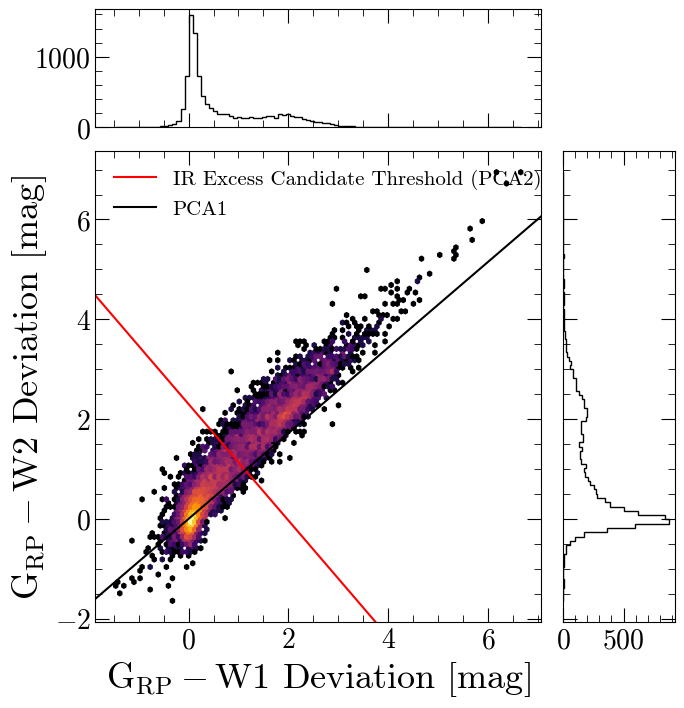

In [16]:
# plot W1 differences against W2 differences
# todo: plot the selected region in the next figure

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.hexbin(x, y, cmap='inferno', bins='log')
    # now determine nice limits by hand:
    binwidth = 0.25
    # plot the histograms
    ax_histx.hist(x, bins=100, color = 'k', histtype = 'step')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'k', histtype = 'step')
    

fig = plt.figure(layout='constrained')

ax = fig.add_gridspec(top=0.75, right=0.75).subplots() # create the figure
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

scatter_hist(catalog['w1_diffs'], catalog['w2_diffs'], ax, ax_histx, ax_histy)
ax.set_xlabel(r'$G_{RP}-W1$ Deviation [mag]')
ax.set_ylabel(r'$G_{RP}-W2$ Deviation [mag]')

# fetch plot limits
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# plot the cutoff threshold
xarr = np.linspace(xlims[0], xlims[1], 10)
ax.plot(xarr, cutoff_line(xarr), c = 'r', label='IR Excess Candidate Threshold (PCA2)')
ax.plot(xarr, m[0]*xarr, c = 'k', label='PCA1')

# reset plot limits
ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.legend(framealpha=0, loc='upper left')

plt.show()

In [17]:
# create a mask for stars with color differences above the cutoff thresholds
excesses = np.any([catalog['w2_diffs'] - cutoff_line(catalog['w1_diffs']) > 0], axis=0)
print(f'no. excess candidates={excesses.sum()}')

no. excess candidates=3296


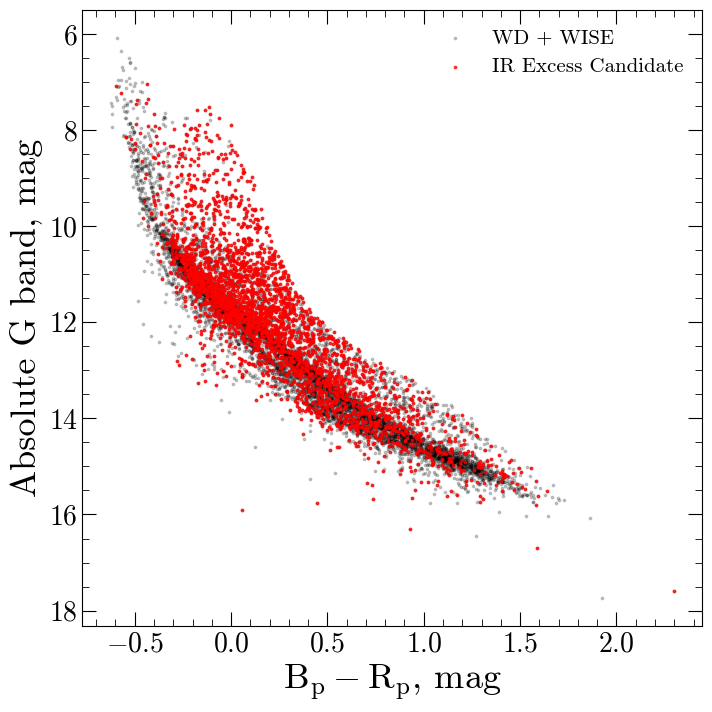

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.2, label = 'WD + WISE')
plt.scatter(catalog[excesses]['bp_rp'], catalog[excesses]['abs_g'], s = 3, c = 'r', alpha = 0.7, label = 'IR Excess Candidate')
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')
plt.legend(framealpha=0)
plt.gca().invert_yaxis()

## Data Cleaning
---

**01. Select WDs in SDSS**

This is the first layer in the cleaning cuts at this stage. I'll save the results into two masks:
* `sdss` : contains all rows in the catalog that are within SDSS in `True`
* `excess_1` : contains the intersection of `sdss` and `excesses`. This is the first layer in the excess cuts.

In [19]:
# fetch the sdss username and password from my super secret library
sdss_uname = keys['sdss5-uname']
sdss_passwd = keys['sdss5-passwd']

# create the url for the spAll file
star_file='spAll-lite-v6_1_0.fits.gz'
star_url='https://data.sdss5.org/sas/sdsswork/bhm/boss/spectro/redux/v6_1_0/'+star_file

#this is a very large file, so use with
with fits.open(star_url, use_fsspec=True, fsspec_kwargs={"auth":aiohttp.BasicAuth(sdss_uname, sdss_passwd)}) as master_tab:
    master_df=pd.DataFrame({'CATALOGID':master_tab[1].data['CATALOGID'].tolist(),
                          'RA':master_tab[1].data['RACAT'].tolist(),
                          'DEC':master_tab[1].data['DECCAT'].tolist(),
                          })
master_df = Table.from_pandas(master_df)

In [20]:
# remove anything that doesn't have a saved RA and DEC in the master catalog
mask = np.all([np.isnan(master_df['RA']), np.isnan(master_df['DEC'])], axis=0)
master_df = master_df[~mask]

# create skycoord rows to be used in the cross-match
catalog['sc'] = SkyCoord(ra=catalog['ra'], dec=catalog['dec'], unit=u.deg)
master_df['sc'] = SkyCoord(ra=master_df['RA']*u.deg, dec=master_df['DEC']*u.deg)

# join the SDSS-V master catalog with a radius of 3 arcseconds
sdss5_join = unique(join(catalog, master_df, keys='sc', join_funcs={'sc': join_skycoord(3 * u.arcsec)}), keys='source_id')
in_sdss5 = np.in1d(catalog['source_id'], sdss5_join['source_id']) # create a mask of rows in SDSS-V

# create the masks listed in the section header
sdss = np.any([in_sdss5, catalog['sdss_clean'] == 1], axis=0)
excess_1 = np.all([sdss, excesses], axis=0)

print('no. sdss5:', in_sdss5.sum(), 'no. sdss4:', (catalog['sdss_clean'] == 1).sum(), 'no. total sdss:', sdss.sum(), 'no. sdss excesses:', excess_1.sum())

# delete the large tables that won't be used later
del master_df

no. sdss5: 1256 no. sdss4: 3341 no. total sdss: 4023 no. sdss excesses: 1174


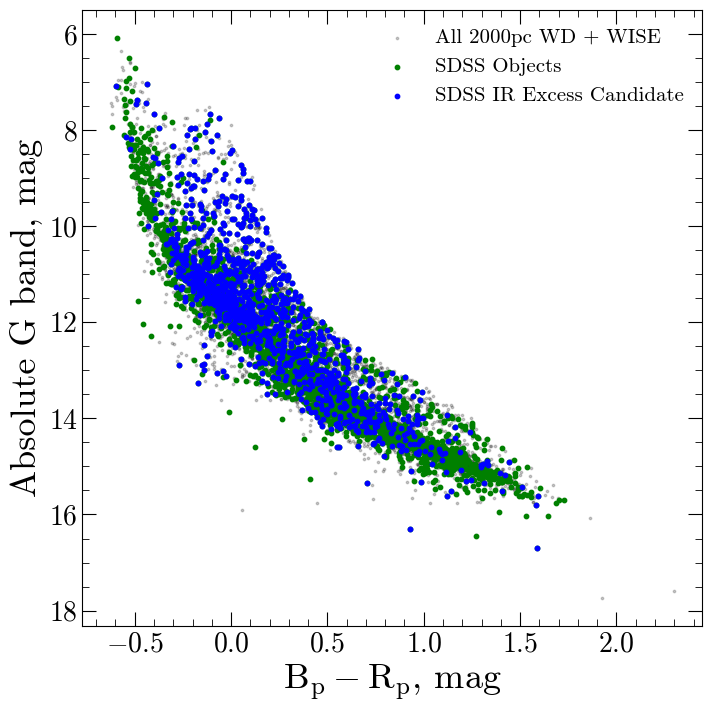

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.2, label = 'All 2000pc WD + WISE')
plt.scatter(catalog[sdss]['bp_rp'], catalog[sdss]['abs_g'], s = 10, c = 'green', alpha = 1, label = 'SDSS Objects')
plt.scatter(catalog[excess_1]['bp_rp'], catalog[excess_1]['abs_g'], s = 10, c = 'blue', alpha = 1, label = 'SDSS IR Excess Candidate')
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')
plt.legend(framealpha=0)
plt.gca().invert_yaxis()

**02. Filter Out CVs In SDSS**

This is the first layer in the cleaning cuts at this stage. I'll save the results in two masks:
* `sdss_cv` : `True` if the row is identified as a CV in SDSS
* `excess_2` : contains the intersection of `excess_1` and `~sdss_cv`. In other words, contains all those excesses that are not also CVs

In [22]:
# filter out sdss4 cvs
sdss4_cvs = Table.read('data/cvs_from_sdss4.csv') # read from Inight+2023b
sdss4_cv = np.in1d(catalog['source_id'], sdss4_cvs['EDR3_source_id']) # build a mask of the shared elements based on source_id

# filter out sdss5 cvs
sdss5_cvs = Table.read('data/cvs_from_sdss5.csv') # read from Inight+2024
sdss5_cvs['sc'] = SkyCoord(ra=sdss5_cvs['ra']*u.deg, dec=sdss5_cvs['dec']*u.deg)
# join the catalog with the SDSS-V CVs at a radius of 3 arcseconds
sdss5_join = unique(join(catalog, sdss5_cvs, keys='sc', join_funcs={'sc': join_skycoord(3 * u.arcsec)}), keys='source_id')
in_sdss5 = np.in1d(catalog['source_id'], sdss5_join['source_id']) # create a mask of rows in SDSS-V

# create masks
print(f'no. sdss4 cvs={sdss4_cv.sum()}')

no. sdss4 cvs=29


NameError: name 'good_sdss4' is not defined

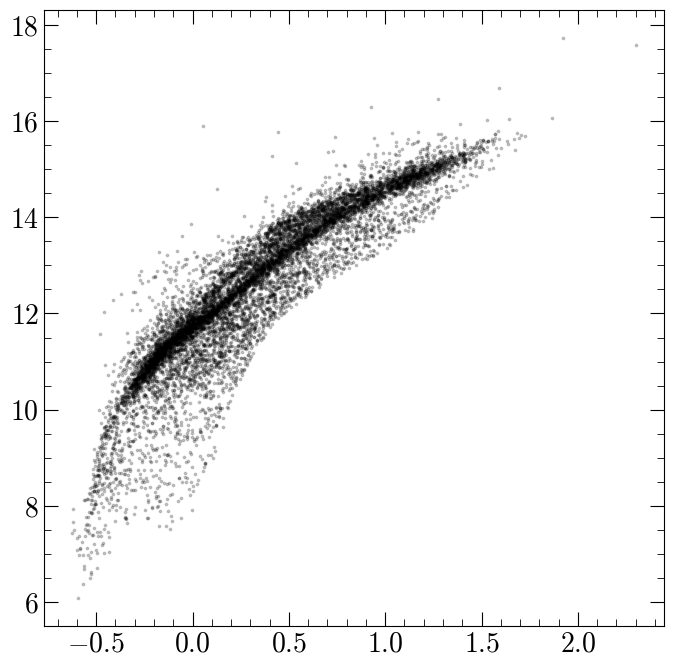

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(catalog['bp_rp'], catalog['abs_g'], s = 3, c = 'k', alpha = 0.2, label = 'All 2000pc WD + WISE')
plt.scatter(catalog[good_sdss4]['bp_rp'], catalog[good_sdss4]['abs_g'], s = 10, c = 'green', alpha = 1, label = 'SDSS-IV WD IR Excess Candidate')
plt.scatter(catalog[excess_cv_sdss4]['bp_rp'], catalog[excess_cv_sdss4]['abs_g'], s = 10, c = 'blue', alpha = 1, label = 'SDSS-IV CV IR Excess Candidate')
plt.xlabel('$B_p-R_p$, mag')
plt.ylabel('Absolute G band, mag')
plt.legend(framealpha=0)
plt.gca().invert_yaxis()

**03 - Remove M Dwarfs!**

https://www.aanda.org/articles/aa/full_html/2020/10/aa38295-20/aa38295-20.html

https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/642/A115